#Import libraries

In [40]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Read the Data

In [5]:
df=pd.read_csv('/content/BTC-USD.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2232,2020-10-27,13075.242188,13759.668945,13060.837891,13654.218750,13654.218750,33749878155
2233,2020-10-28,13654.214844,13837.695313,12932.250977,13271.285156,13271.285156,35867318894
2234,2020-10-29,13271.298828,13612.047852,12980.059570,13437.882813,13437.882813,56499499598
2235,2020-10-30,13437.874023,13651.516602,13136.198242,13546.522461,13546.522461,30581485200


In [41]:
df.iloc[:,1].describe()

count     2237.000000
mean      4535.608790
std       4212.560412
min        176.897003
25%        437.436005
50%       3704.216309
75%       8162.190918
max      19475.800781
Name: Open, dtype: float64

#Split The Data and Visualize it

In [44]:
X=(df['Open'].values).reshape(2237,1)


In [45]:
X_train=X[:2000,:]

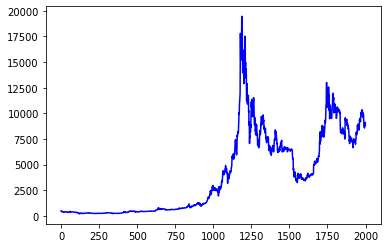

In [46]:
plt.plot(X_train,c='b')

#Scale the data

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))


In [9]:
X_train=scaler.fit_transform(X_train)

#Create Sequences

In [10]:
def dataset(X,timesteps):
  x=[]
  y=[]
  for i in range(0,len(X)-1-timesteps):
    x.append(X[i:i+timesteps,0])
    y.append(X[i+timesteps,0])
  return np.array(x),np.array(y)


In [11]:
X_tr,Y_tr=dataset(X_train,30)
X_tr.shape,Y_tr.shape

((1969, 30), (1969,))

In [12]:
X_tr=X_tr.reshape(X_tr.shape[0],X_tr.shape[1],1)
X_tr.shape

(1969, 30, 1)

#The Model

In [13]:
model=Sequential()
model.add(LSTM(30,activation='tanh',input_shape=(X_tr.shape[1],X_tr.shape[2]),return_sequences=True))
model.add(LSTM(30,activation='tanh',return_sequences=False))
model.add(Dense(1,activation='linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
model.compile(optimizer='adam',loss='mse')

In [18]:
hist=model.fit(X_tr,Y_tr,epochs=50,batch_size=32)

Epoch 1/50
62/62 [==============================] - 0s 6ms/step - loss: 2.3667e-04
Epoch 2/50
62/62 [==============================] - 0s 6ms/step - loss: 2.3789e-04
Epoch 3/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7109e-04
Epoch 4/50
62/62 [==============================] - 0s 6ms/step - loss: 2.4555e-04
Epoch 5/50
62/62 [==============================] - 0s 6ms/step - loss: 2.5010e-04
Epoch 6/50
62/62 [==============================] - 0s 6ms/step - loss: 2.6106e-04
Epoch 7/50
62/62 [==============================] - 0s 6ms/step - loss: 2.4749e-04
Epoch 8/50
62/62 [==============================] - 0s 6ms/step - loss: 2.2600e-04
Epoch 9/50
62/62 [==============================] - 0s 6ms/step - loss: 2.2931e-04
Epoch 10/50
62/62 [==============================] - 0s 6ms/step - loss: 2.3246e-04
Epoch 11/50
62/62 [==============================] - 0s 6ms/step - loss: 2.4778e-04
Epoch 12/50
62/62 [==============================] - 0s 6ms/step - loss: 2.4524e-04
E

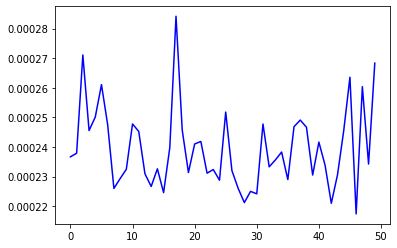

In [47]:
plt.plot(hist.history['loss'],c='b')

#Check for The Test Data

In [19]:
X_test=X[2000:,:]
scaler1=MinMaxScaler(feature_range=(0,1))

In [20]:
X_test=scaler1.fit_transform(X_test)

In [21]:
X_te,Y_te=dataset(X_test,30)
X_te.shape,Y_te.shape

((206, 30), (206,))

In [22]:
X_te=X_te.reshape(X_te.shape[0],X_te.shape[1],1)
X_te.shape

(206, 30, 1)

In [23]:
Y_te=Y_te.reshape(Y_te.shape[0],1)

#The Prediction

In [24]:
Y_pred=model.predict(X_te)

#Compare predictions with original data

In [25]:
Y_prediction=scaler1.inverse_transform(Y_pred)
Y_te=scaler1.inverse_transform(Y_te)

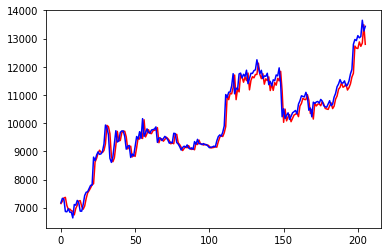

In [27]:
plt.plot(Y_prediction,c='r')
plt.plot(Y_te,c='b')
plt.show()

#Check for 'n' next days

In [32]:
def update(X_check,Y_new,Y_final):
  e=float(Y_new[0])
  d=X_check
  d[0,0]=0
  d[0,29]=e
  Y_final.append(e)
  X_check=d
  return X_check,(Y_final)

In [37]:
def predict_next(days):
  X_check=np.array(X[2236-29:])
  X_check=X_check.reshape(-1,1)
  X_check=scaler1.fit_transform(X_check)
  X_check=X_check.reshape((1,30,1))
  Y_final=[]
  for i in range(0,days):
    Y_new=model.predict(X_check)
    X_check,Y_final=update(X_check,Y_new,Y_final)
  return scaler1.inverse_transform(np.array(Y_final).reshape(days,1))

In [38]:
days=int(input("Enter The no of days you want to predict for: "))
final_prediction=predict_next(days)

Enter The no of days you want to predict for: 10


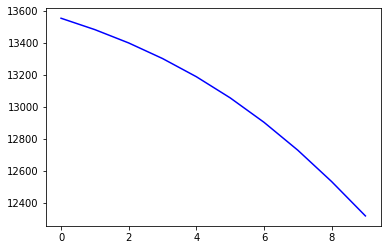

In [39]:
plt.plot(final_prediction,c='b')